In [3]:
%pip install pandas
%pip install geopandas
%pip install pyproj

  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl (11.0 MB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/12.8 MB 12.6 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.8 MB 22.1 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.8 MB 22.1 MB/s eta 0:00:01
   -------------------------- ------------- 8.4/12.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------- ----------- 9.2/12.8 MB 9.8 MB/s eta 0:00:01
   ------------------------------- -------- 10.0/12.8 MB 8.7 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.8 MB 7.7 MB/s eta 0:00:01
   ------------------------------------ --- 11.5/12.8 MB 7.2 MB/s eta 0:00:01
   --------------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ------ --------------------------------- 3.1/19.2 MB 18.5 MB/s eta 0:00:01
   ------------- -------------------------- 6.6/19.2 MB 25.2 MB/s eta 0:00:01
   --------------- ------------------------ 7.6/19.2 MB 13.8 MB/s eta 0:00:01
   ------------------ --------------------- 8.7/19.2 MB 10.7 MB/s eta 0:00:01
   ------------------- -------------------- 9.2/19.2 MB 9.7 MB/s eta 0:00:02
   -------------------- ------------------- 10.0/19.2 MB 8.4 MB/s eta 0:00:02
   --------------------- ------------------ 10.5/19.2 MB 7.9 MB/s eta 0:00:02
   ------------------------ --------------- 11.5/19.2 MB 7.1 MB/s eta 0:00:02
   ------------------------- -------------- 12.3/19.2 MB 6.7 MB/s eta 0:00:02
   -------------------------- ------------- 12.8/19.2 MB 6.5 MB/s eta 0:00:01
   ---------------------------- ----------- 13.9/19.2 MB 6.1 MB/s eta 0:00:01
   ------------------------------ --------- 14.7/19.2 MB 5.9 MB/s eta 0:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import geopandas as gpd
# import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS

LOAD DATA

In [10]:
#Load Massachusetts Trail Data
trails = gpd.read_file("../data/MA_State_Trails.geojson")
print("Trail Data Loaded!")
#Set global CRS
PROJECTION = trails.crs
# trails.plot()

Trail Data Loaded!


In [37]:
#Select by Name
def get_trail_by_name(name):
    return trails[trails["name"] == name]

iNaturalist API

In [23]:
def api_get_trail_by_name(name: str):
    result = trails[trails["name"].str.lower() == name.lower()]
    if result.empty:
        return {"message": f"No trail found with name '{name}'."}
    
    # Drop all datetime columns
    datetime_cols = [col for col in result.columns if result[col].dtype.kind in "Mm"]  # M = datetime64, m = timedelta
    result = result.drop(columns=datetime_cols)

    return result.to_json()

api_get_trail_by_name("Norwottuck Rail Trail")

'{"type": "FeatureCollection", "features": [{"id": "9358", "type": "Feature", "properties": {"permanentidentifier": "{40735EB0-2B5A-4769-857A-D351CAA8485F}", "name": "Norwottuck Rail Trail", "namealternate": null, "trailnumber": null, "trailnumberalternate": null, "sourcefeatureid": null, "sourcedatasetid": "{0914CC36-E311-4F84-9D65-8E8EBE7ED090}", "sourcedatadecscription": "Massachusetts State Trails 05/2020", "sourceoriginator": "MassGIS (Bureau of Geographic Information)", "trailtype": "Terra Trail", "hikerpedestrian": null, "bicycle": null, "packsaddle": null, "atv": null, "motorcycle": null, "ohvover50inches": null, "snowshoe": null, "crosscountryski": null, "dogsled": null, "snowmobile": null, "nonmotorizedwatercraft": null, "motorizedwatercraft": null, "primarytrailmaintainer": "State", "nationaltraildesignation": null, "lengthmiles": 1.93377392, "networklength": 28137.052849170002, "globalid": "{7654B6B9-D73D-42D4-B0F8-31E718C73DFA}", "shape_Length": 0.03414400967143694}, "geom

Bounding Box, SW: (-72.62998167323978, 42.329292943867486) NE: (-72.46336871872809, 42.369992539971186)


0                 Coral Saucer
1               Dryad's Saddle
2            flocculose inkcap
3                 black locust
4      White-breasted Nuthatch
                ...           
195          Resinous Polypore
196         Woolly Alder Aphid
197        Isabella Tiger Moth
198                   Fallfish
199         Large Milkweed Bug
Name: species_guess, Length: 200, dtype: object

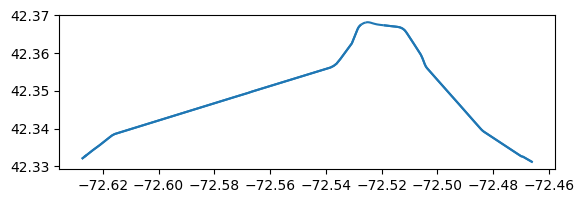

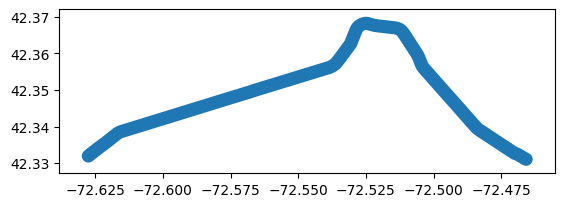

In [9]:
TRAIL_BUFFER = 200 #meters

#Select trail
trail = get_trail_by_name(trails, 'Norwottuck Rail Trail')
trail.plot()
#Add buffer:
trail = trail.to_crs(epsg=5070) #to metered projection
trail = gpd.GeoDataFrame(geometry=trail.buffer(TRAIL_BUFFER), crs=trail.crs)
trail = trail.dissolve()
trail = trail.to_crs(crs=PROJECTION) #back to original CRS
trail.plot()

#Get bounding box
SW_Lng, SW_Lat, NE_Lng, NE_Lat = trail.total_bounds
print(f"Bounding Box, SW: ({SW_Lng}, {SW_Lat}) NE: ({NE_Lng}, {NE_Lat})")

from datetime import datetime
curr_month = datetime.now().month
if curr_month == 1:
    last_month = 12
else:
    last_month = curr_month - 1
if curr_month == 12:
    next_month = 1
else:
    next_month = curr_month + 1

#Send url request
import requests


iNat_url = "https://api.inaturalist.org/v1/observations"
params = {
    "swlng": SW_Lng,
    "swlat": SW_Lat,
    "nelng": NE_Lng,
    "nelat": NE_Lat,      
    "quality_grade": "research",
    "per_page": 200,
    "page": 1,
    "month": [last_month, curr_month, last_month],        
    "year": [2022, 2023, 2024],     # last 3 years
    "order_by": "observed_on"
}

r = requests.get(iNat_url, params=params)
data = r.json()
observations = pd.json_normalize(data["results"])
species = observations["species_guess"]
display(species)

In [10]:
r.url

'https://api.inaturalist.org/v1/observations?swlng=-72.62998167323978&swlat=42.329292943867486&nelng=-72.46336871872809&nelat=42.369992539971186&quality_grade=research&per_page=200&page=1&month=9&month=10&month=9&year=2022&year=2023&year=2024&order_by=observed_on'

In [52]:
import requests

In [53]:
def get_species_by_trail(
    trail_name: str,
    current_month: int 
):
    TRAIL_BUFFER = 200 #meters

    #Select trail
    trail = get_trail_by_name(trail_name)

    # trail.plot()
    #Add buffer:
    trail = trail.to_crs(epsg=5070) #to metered projection
    trail = gpd.GeoDataFrame(geometry=trail.buffer(TRAIL_BUFFER), crs=trail.crs)
    trail = trail.dissolve()
    trail = trail.to_crs(crs=PROJECTION) #back to original CRS
    # trail.plot()

    #Get bounding box
    SW_Lng, SW_Lat, NE_Lng, NE_Lat = trail.total_bounds
    # print(f"Bounding Box, SW: ({SW_Lng}, {SW_Lat}) NE: ({NE_Lng}, {NE_Lat})")

    # from datetime import datetime
    curr_month = current_month # a number
    if curr_month == 1:
        last_month = 12
    else:
        last_month = curr_month - 1
    if curr_month == 12:
        next_month = 1
    else:
        next_month = curr_month + 1

    iNat_url = "https://api.inaturalist.org/v1/observations"
    params = {
        "swlng": SW_Lng,
        "swlat": SW_Lat,
        "nelng": NE_Lng,
        "nelat": NE_Lat,      
        "quality_grade": "research",
        "per_page": 200,
        "page": 1,
        "month": [last_month, curr_month, last_month],        
        "year": [2022, 2023, 2024],     # last 3 years
        "order_by": "observed_on"
    }

    r = requests.get(iNat_url, params=params)
    
    data = r.json()
    observations = pd.json_normalize(data["results"])
    species = observations["species_guess"]
    # display(species)    
    return species.to_json()



In [56]:
get_species_by_trail("Norwottuck Rail Trail", 12                    )


'{"0":"intermediate wood fern","1":"prickly tree-clubmoss","2":"Dark-eyed Junco","3":"Song Sparrow","4":"American Tree Sparrow","5":"American Tree Sparrow","6":"Northern Cardinal","7":"winged euonymus","8":"black locust","9":"common milkweed","10":"Northern Harrier","11":"Merlin","12":"Song Sparrow","13":"Song Sparrow","14":"Song Sparrow","15":"Song Sparrow","16":"Red-tailed Hawk","17":"Savannah Sparrow","18":"boxelder","19":"American beech","20":"Northern Harrier","21":"Savannah Sparrow","22":"Northern Harrier","23":"Canada Goose","24":"Common Merganser","25":"Common Merganser","26":"Red-tailed Hawk","27":"Bobcat","28":"Domestic Cat","29":"Savannah Sparrow","30":"black locust","31":"House Finch","32":"Dark-eyed Junco","33":"House Finch","34":"Song Sparrow","35":"Northern Cardinal","36":"Merlin","37":"Merlin","38":"European Starling","39":"Bobcat","40":"Pileated Woodpecker","41":"sensitive fern","42":"eastern white pine","43":"Barred Owl","44":"border privet","45":"Eastern Gray Squirre